# Towards spectral super-resolution in solar absorption lines from pseudomonochromatic images

## Experiment 3. Spectral super-resolution with SIREN

This is a PyTorch implementation of the experiment presented in the study ["Implicit Neural Representations
with Periodic Activation Functions"](https://www.vincentsitzmann.com/siren/) by Sitzmann et al.

### Choose envinroment, libraries and source files

#### Envinroment

In [1]:
# Attempt to import the necessary modules for Google Colab environment
try:
    # If running in Google Colab, import the drive module from google.colab
    from google.colab import drive
    # This mounts the Google Drive to the Colab VM, allowing access to its files.
    drive.mount('/content/drive')

    # Define the base path to the project folder within Google Drive
    PATH = '/content/drive/MyDrive/Colab Notebooks/FHN/assets/'
    # Concatenate the base path with specific subdirectories for source code, images, and outputs
    SRC_PATH = PATH + 'src/'  # Path to source code
    IMG_PATH = PATH + 'images/sol.h5'  # Path to a specific image file
    MODEL_PATH = PATH + 'outputs/models/SUPERSIREN/'  # Path to output models directory
    IMAGES_PATH = PATH + 'outputs/results/SUPERSIREN/images/' # Path to output images directory
    VIDEO_PATH = PATH + 'outputs/results/SUPERSIREN/videos/' # Path to output videos directory
    LOGS_PATH = PATH + 'outputs/results/SUPERSIREN/logs/' # Path to output log profiler directory

# If the google.colab module is not found (meaning not running in Google Colab),
# fallback to a local environment setup.
except ImportError:
    # Define local paths assuming the Jupyter Notebook is running in a local environment
    SRC_PATH = 'assets/src/'  # Local path to source code
    IMG_PATH = 'assets/images/sol.h5'  # Local path to a specific image file
    MODEL_PATH = 'assets/outputs/models/SUPERSIREN/'  # Local path to output models directory
    IMAGES_PATH = 'assets/outputs/results/SUPERSIREN/images/' # Path to output images directory
    VIDEO_PATH = 'assets/outputs/results/SUPERSIREN/videos/' # Path to output videos directory
    LOGS_PATH = 'assets/outputs/results/SUPERSIREN/logs/' # Path to output log profiler directory

Mounted at /content/drive


#### Libraries

In [2]:
# Import the 'sys' library to interact with the Python runtime environment.
import sys

# Import the 'copy' module from Python's standard library.
# This module provides the 'deepcopy' function, which can be used
# to create deep copies of mutable objects like dictionaries.
import copy

# Import the 'time' module to measure the time elapsed during certain operations or code execution
import time

# Import the NumPy library and rename it as np.
# NumPy is a library for numerical computing in Python and is especially useful for array operations.
import numpy as np

# Import the 'tqdm' function from the 'tqdm.auto' module for displaying progress bars in Jupyter notebooks or consoles.
from tqdm.auto import tqdm

# Import the pyplot module from the Matplotlib library and rename it as plt.
# Matplotlib is a library for creating static, interactive, and animated visualizations in Python.
import matplotlib.pyplot as plt

# Import the 'seaborn' library for data visualization. Seaborn is based on Matplotlib
# and provides a high-level interface for drawing attractive and informative statistical graphics.
import seaborn

# Import the PyTorch library for deep learning.
# PyTorch is an open-source machine learning library used for a variety of tasks,
# including classification, regression, and image generation.
import torch

# Import the functional module from nn and rename it as F.
# This module contains functions that can be used in defining operations of a neural network,
# such as activations and losses.
import torch.nn.functional as F

# Importing necessary modules from torchvision.transforms
# Compose: Composes several transforms together into a single transform
# Normalize: Normalizes a tensor image with mean and standard deviation
from torchvision.transforms import Compose, Normalize

#### Source files

In [3]:
# Append the SRC_PATH directory to the system path to make its modules accessible.
sys.path.append(SRC_PATH)

In [4]:
# Import all functions and variables from the 'utils' module located in the 'assets/src/' directory.
from utils import (set_seed, smooth_curve, get_data, get_experiment_data,
                   plot_data, crop, time_formatter, feat_scaling, info, normalize)
from dataset import grid3D, split_data_2D
from training import train, generate_B, fourier_mapping
from models import NeuralFieldSiren

### Random seed for reproducibility

In [5]:
# Set the random seed to 42 for reproducibility.
seed = 42
set_seed(seed)

### Get the available device

#### Minimum Recommended Hardware Requirements

To perform the training within an acceptable time frame, it is highly recommended to have access to a GPU. The original experiment was conducted using the following GPU configuration:

- **CUDA Availability**: Yes
- **GPU Model**: Tesla T4
- **Total Memory**: 15360.0 MiB
- **Free Memory**: 11392.0 MiB
- **Memory Used**: 3709.0 MiB
- **Timestamp**: Tue Aug 1 07:29:13 2023

```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |   3709MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
+-----------------------------------------------------------------------------+
```

In [6]:
model = !nvidia-smi --query-gpu=name --format=csv,noheader
GPU = model[0]

In [7]:
# Define the 'device' variable to specify where the code will run (CPU or GPU).
# Use the GPU (CUDA) if available; otherwise, use the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the available device to inform the user.
# This is useful for debugging and to ensure the code is running on the desired device.
print("Available device:", device)

Available device: cuda


### Solar images

<p align='justify'>For the PFG, we have a real spectral data cube I(x, y, λ) of the photospheric absorption line of neutral iron (that is, non-ionized) centered at 6302 Å (Fe I λ6302). Specifically, there are 21 pseudomonochromatic images, each with dimensions of 966x964 pixels, covering a large area of the Sun's surface. These images "scan" the Fe I λ6302 absorption line across 21 narrow wavelength (λ) intervals.</p>

In [8]:
# Call the 'get_data' function to read the image data from the specified path and store it in the variable 'cube'.
cube = get_data(IMG_PATH)

# Get the number of images in the cube by accessing the first dimension of its shape.
NUM_IMAGES = cube.shape[0]

# Create labels for the wavelengths. The labels are in the format 'λ = n', where n starts from 1 and goes up to NUM_IMAGES.
wl_lbls = [f'$\\lambda_{{{label + 1}}}$' for label in np.arange(0, NUM_IMAGES)]

First key: cube


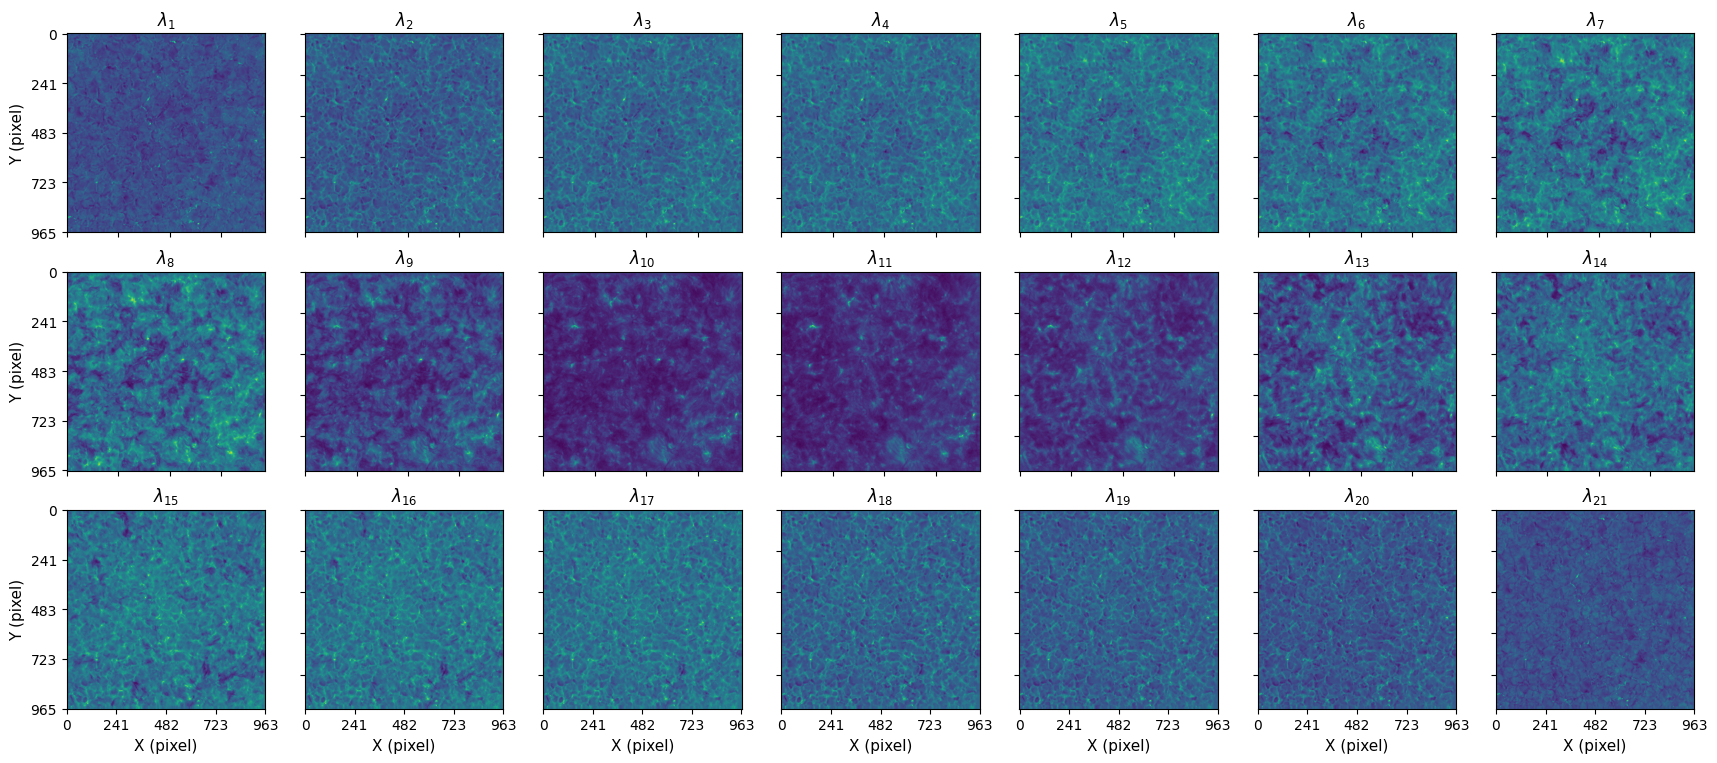

In [9]:
# Call the plot_data function to visualize the 'cube' dataset
plot_data(dataset=cube, num_columns=7,
          labels=wl_lbls, tick_size=10,
          title_size=12, axis_size=11,
          path=IMAGES_PATH, img_name='solar_dataset',
          hspace=0.1, wspace=0.2)

### Experiment Settings

#### Paremeters

In [10]:
# Define a list of loss functions to be used in the training process.
# The list includes L1 loss, MSE loss, and Smooth L1 loss.
loss_functions = [F.l1_loss, F.mse_loss, F.smooth_l1_loss]

# Initialize lists to store different values for the omega_0 parameter in SIREN.
# omega_0 is the frequency factor that multiplies the activations before the nonlinearity in the first layer.
# Different values of omega_0 can affect the model's ability to represent high-frequency functions.
omega_0 = [30., 50.]

# Initialize lists to store different values for the hidden_omega_0 parameter in SIREN.
# hidden_omega_0 is the frequency factor for the hidden layers in the SIREN model.
# Different values can affect how well the hidden layers capture the details of the function being approximated.
hidden_omega_0 = [30., 50.]

In [11]:
# Comment this two lines for complete training or uncomment for single training
# omega_0 = [30.]
# hidden_omega_0 = [30.]

In [12]:
# Initialize an empty dictionary to store the configuration parameters for the experiment.
config = {}

# Store the hardware information (either CPU or GPU details) in the 'info' key of the config dictionary
config['HARDWARE'] = info()

# Set the index of the image to be used from the data cube.
config['IMG_INDEX'] = np.arange(0, NUM_IMAGES)

# Set the size of the image crop to be used for training.
config['CROP_SIZE'] = 512

# Set the 'OMEGA' key. This value will be used as the frequency factor for the first layer in the SIREN model.
config['OMEGA'] = omega_0[0]

# Set the 'HIDDEN_OMEGA' key. This value will be used as the frequency factor for the hidden layers in the SIREN model.
config['HIDDEN_OMEGA'] = omega_0[0]

# Set the learning rate for the optimizer.
config['LR'] = 1e-4

# Set the loss function to be used for training.
config['LOSS'] = loss_functions[1]

# Set the number of epochs for training.
config['EPOCHS'] = 2000

#### SIREN (SInusoidal REpresentation Networks)

In our experiment, we also explore the use of SIREN, a neural network architecture that employs sinusoidal activation functions to represent complex functions and signals. SIREN is particularly well-suited for representing high-frequency details, making it an excellent choice for tasks that require fine-grained reconstructions or approximations.

The key innovation in SIREN is the use of sinusoidal activation functions in the form of $\sin(\omega \mathbf{W} \mathbf{x} + \mathbf{b})$, where $\omega$ is a frequency parameter, $\mathbf{W}$ is the weight matrix, and $\mathbf{b}$ is the bias vector. The frequency parameter $\omega$ is crucial for controlling the expressiveness of the network. It allows SIREN to adapt to various scales and frequencies in the data.

#### SIREN Architecture in Our Experiment

In our implementation, the SIREN architecture consists of:

- An input layer that takes the pixel coordinates $(x, y, λ)$ as input and applies a sinusoidal activation function with a frequency parameter $\omega_0$.
  
- Multiple hidden layers that also use sinusoidal activation functions, each with their own frequency parameter $\omega$.

- An output layer that produces the pixel intensity value for the given coordinates.

#### Frequency Parameters

For our experiment, we explore different frequency parameters $\omega_0$ for the input layer and $\omega$ for the hidden layers. Specifically, we investigate the following:

- Input layer frequency $\omega_0$: [30., 50.]
  
- Hidden layer frequency $\omega$: [30., 50.]

By incorporating SIREN into our neural field model, we aim to capture high-frequency details more effectively and improve the quality of the reconstructed or approximated images.

#### Obtaining the image for the experiment

In [13]:
# Retrieve one of the images from the cube dataset using the specified index from the config dictionary
images = get_experiment_data(cube)

# Crop the image to create a patch of size (CROP_SIZE x CROP_SIZE) as specified in the config dictionary
images = crop(images, config['CROP_SIZE'])

# Normalize the pixel intensity values of the image to the range [0, 1] using feature scaling
images, (min_, max_) = feat_scaling(images)

# Normalize the pixel intensity values of the image to the range [0, 1] using normalize
# images, (min_, max_) = normalize(images)

# Save GT image to config dictionary
config['GT_IMG'] = images

# Create an array of wavelengths ranging from config['IMG_INDEX'] array
wavelengths = config['IMG_INDEX']

# Create labels for the wavelengths. The labels are in the format 'λ_n'
lbls = [f'$\\lambda_{{{label + 1}}}$' for label in wavelengths]

# Initialize a Compose object from torchvision.transforms to apply a sequence of transformations.
# In this case, the only transformation is Normalize,
# which normalizes the tensor with a mean of 0.5 and a standard deviation of 0.5.
# transform = Compose([
#    Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
# ])

# Apply the normalization transformation to tensor_norm.
# This will shift and scale the values in tensor_norm to be between -1 and 1.
# images = transform(images)

#### Obtaining the grid of normalized coordinates

In [14]:
# Obtain the grid of normalized coordinates in the interval [0, 1]
coords = grid3D(images)

# Obtain the grid of normalized coordinates in the interval [-1, 1]
# coords = grid3D(data=images, ini_dim=-1)

# Save the grid to config dictionary
config['COORDS_VAL'] = coords

#### Getting the training and test datasets

In [15]:
# Use the function to split the data into training and testing sets.
train_loader, test_loader = split_data_2D(coords, images, wavelengths, device=device, bs=8)

#### Info

In [16]:
# Downsample the coordinates by taking every other pixel along the width and height.
coords_train = coords[:, :, ::2, ::2]

# Downsample the image by taking every other pixel along the width and height.
images_train = images[:, :, ::2, ::2]

# Print the shape of the original coordinates tensor.
print(f'Coordinates: {coords.shape}')

# Print the shape of the original image tensor.
print(f'Image: {images.shape}')

# Print the shape of the downsampled coordinates tensor.
print(f'Coordinates train: {coords_train.shape}')

# Print the shape of the downsampled image tensor.
print(f'Image train: {images_train.shape}')

# Retrieve the next batch of data and labels from the test_loader
x, y, _ = next(iter(train_loader))

# Print the shape of the batch data
print(f'First batch coords: {x.shape}')

# Print the shape of the batch labels
print(f'First batch labels: {y.shape}')

Coordinates: torch.Size([21, 3, 512, 512])
Image: torch.Size([21, 1, 512, 512])
Coordinates train: torch.Size([21, 3, 256, 256])
Image train: torch.Size([21, 1, 256, 256])
First batch coords: torch.Size([8, 3, 256, 256])
First batch labels: torch.Size([8, 1, 256, 256])


### Obtain an instance of the Neural Field model with SIREN

In [17]:
def instance_SIREN(lr=1, f0=30., h0=30., device='cpu'):
    """
    This function initializes an instance of a NeuralFieldSiren model along with an Adam optimizer.

    Parameters:
    - lr (float): The learning rate for the Adam optimizer. Default is 1.
    - f0 (float): The frequency parameter omega_0 for the input layer of the SIREN model. Default is 30.
    - h0 (float): The frequency parameter omega_0 for the hidden layers of the SIREN model. Default is 30.
    - device (str): The device ('cpu' or 'cuda') where the model will be deployed. Default is 'cpu'.

    Returns:
    - model (NeuralFieldSiren): An instance of the NeuralFieldSiren model.
    - optimizer (torch.optim.Adam): An instance of the Adam optimizer.
    """

    # Initialize the NeuralFieldSiren model with the given parameters
    model = NeuralFieldSiren(in_features=3, out_features=1, hidden_features=256,
                             first_omega_0=f0, hidden_omega_0=h0,
                             hidden_layers=3, outermost_linear=True).to(device)

    # Initialize the Adam optimizer with the given learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Return the model and optimizer instances
    return model, optimizer

### Training routine function

In [18]:
def train_model(model, optimizer, config, train_loader, val_loader,
                process=False, base_dir=None, filename=None):

    # Record the start time for training
    start_time = time.time()

    #################################################################
    # Perform the training using the specified loss function,
    # optimizer, and other configurations
    output, best = train(model, optimizer,
                         config['LOSS'], config['EPOCHS'],
                         train_loader, val_loader, print_every=500,
                         device=device, process=process,
                         base_dir=base_dir, filename=filename)
    #################################################################

    # Record the end time for training
    end_time = time.time()

    # Calculate and store the total training time
    config['TRAINING_TIME'] = time_formatter(end_time - start_time)

    # Print the total training time
    print(f"El tiempo total de entrenamiento fue de {config['TRAINING_TIME']}.")

    return output, best

### Training

In [19]:
# Initialize empty dics to store the trained models and their corresponding dictionaries
models = {}
dics = {}

# Loop through each value in the list of omega_0 frequencies
for omega in omega_0:
    # Update the configuration dictionary with the current omega value for both initial and hidden layers
    config['OMEGA'] = omega
    config['HIDDEN_OMEGA'] = omega
    print(f"ω = {config['OMEGA']}")

    # Create an instance of the SIREN model and its optimizer with the current omega and other configurations
    model, optimizer = instance_SIREN(lr=config['LR'], f0=omega, h0=omega, device=device)

    base_dir = LOGS_PATH
    filename = f"{GPU}/ω={config['OMEGA']}"

    # Train the model and obtain the output metrics and the best model
    output, best = train_model(model, optimizer, config, train_loader, test_loader,
                               base_dir=base_dir, filename=filename)

    # Append a deep copy of the best model to the models list
    models[f'{omega}'] = copy.deepcopy(best)

    # Add a deep copy of the configuration used for this model to the 'best' dictionary
    output['config'] = copy.deepcopy(config)

    # Append the output metrics to the dics list
    dics[f'{omega}'] = output

ω = 30.0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 0.0009, test Loss: 0.0009
PSNR: 30.2901, test PSNR: 30.5096
Epoch 1000/2000, Loss: 0.0006, test Loss: 0.0006
PSNR: 32.2560, test PSNR: 32.2135
Epoch 1500/2000, Loss: 0.0005, test Loss: 0.0005
PSNR: 32.7341, test PSNR: 32.8854
Epoch 2000/2000, Loss: 0.0005, test Loss: 0.0004
PSNR: 33.4542, test PSNR: 33.7899
El tiempo total de entrenamiento fue de 20.0 minutes 32.83 seconds.
ω = 50.0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 0.0006, test Loss: 0.0006
PSNR: 32.0912, test PSNR: 32.3098
Epoch 1000/2000, Loss: 0.0005, test Loss: 0.0004
PSNR: 33.1178, test PSNR: 33.5254
Epoch 1500/2000, Loss: 0.0004, test Loss: 0.0004
PSNR: 33.8988, test PSNR: 34.2012
Epoch 2000/2000, Loss: 0.0005, test Loss: 0.0004
PSNR: 33.3446, test PSNR: 33.7622
El tiempo total de entrenamiento fue de 20.0 minutes 31.79 seconds.


### Outputs

#### Get the best generated images from each model

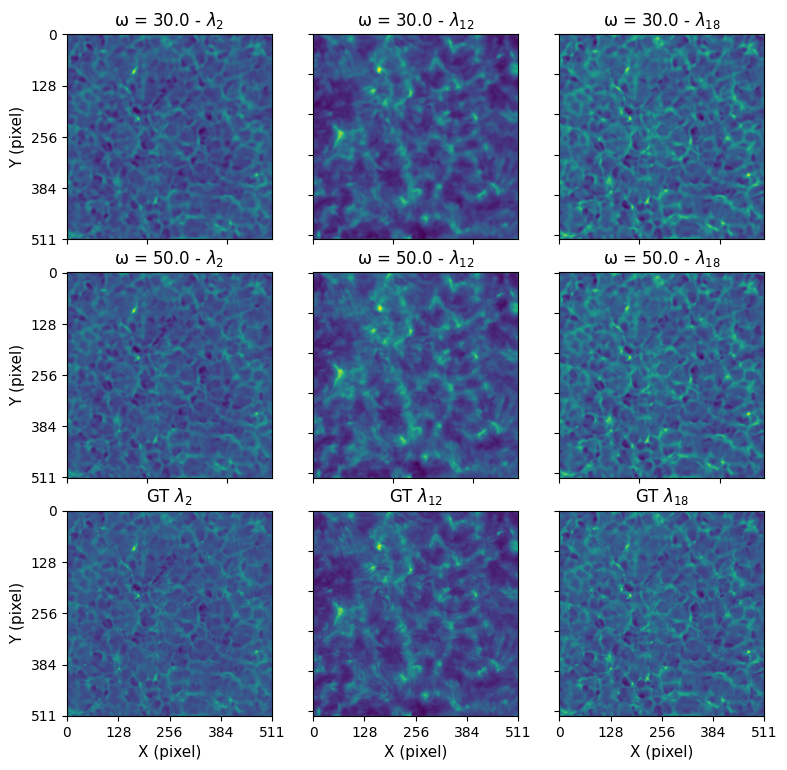

In [20]:
# Define the indices of the images to be used
im_index = [1, 11, 17]

# Initialize empty lists to store all generated images and their corresponding labels
all_generated = []
all_lbl_gen = []

# Loop through each SIREN model stored in the 'models' dictionary
for s, model in models.items():
    # Set the model to evaluation mode
    model.eval()

    # Loop through each image index specified in 'im_index'
    for i in im_index:
        # Generate an image using the current SIREN model and the coordinates of the image at index 'i'
        gen_img = model(coords[i].unsqueeze(0).to(device))
        all_generated.append(gen_img)

        # Create a label for the generated image, indicating the omega value and the wavelength
        all_lbl_gen.append(f'ω = {s} - $\\lambda_{{{wavelengths[i] + 1}}}$')

# Concatenate all generated images along dimension 0, remove singleton dimensions, and convert to a NumPy array
all_generated_images = torch.cat(all_generated, dim=0).squeeze().detach().cpu().numpy()

# Select the ground truth images at the indices specified in 'im_index', remove singleton dimensions, and convert to a NumPy array
gt_images = images[im_index].squeeze().detach().numpy()

# Create labels for the selected ground truth images
lbls_gt = [f'GT $\\lambda_{{{label + 1}}}$' for label in im_index]

# Concatenate the labels for generated and GT images
all_labels = all_lbl_gen + lbls_gt

# Concatenate the generated images and GT images for plotting
all_images_to_plot = np.concatenate((all_generated_images, gt_images), axis=0)

# Utilizes the 'plot_data' function from the 'utils' module to display the images.
# The images are arranged in a grid with 3 columns, and each image is labeled according to the 'labels' list.
plot_data(dataset=all_images_to_plot, num_columns=len(im_index),
          labels=all_labels, tick_size=10,
          title_size=12, axis_size=11,
          path=IMAGES_PATH, img_name='generated_and_GT',
          hspace=0.1, wspace=0.2)


#### Graphical representation of metrics for the training and test sets

In [21]:
# Define metrics and their corresponding y-axis labels
metrics = ['psnr', 'test_psnr', 'loss', 'test_loss']
y_labels = ['TRAIN PSNR', 'TEST PSNR', 'TRAIN Loss', 'TEST Loss']

# Define y-axis limits for PSNR and Loss plots
y_limits = [(10, 40), (10, 40), (-0.001, 0.06), (-0.001, 0.06)]

In [22]:
def plot_metrics(dics, metrics, y_labels, y_limits, suplt=1, smooth=.93):
  # from seaborn.relational import lineplot
  # Set the Seaborn theme for better visualization
  seaborn.set()
  seaborn.set_theme()

  # Create a figure and axes with two rows and two columns
  fig, axs = plt.subplots(suplt, 2, figsize=(16, 6))

  # Generate x-values based on the number of epochs
  xs = np.arange(1, config['EPOCHS'] + 1)

  # Loop through each subplot to plot the data
  for i, ax in enumerate(axs.flatten()):
      metric = metrics[i]  # Get the metric to be plotted for this subplot
      # Set the line style based on the subplot index (even or odd)
      if (i % 2 == 0):
          line = '--'  # Dashed line for even-indexed subplots
      else:
          line = '-'  # Solid line for odd-indexed subplots

      y_label = y_labels[i]  # Get the y-axis label for this subplot
      y_min, y_max = y_limits[i]  # Get the y-axis limits for this subplot

      # Plot the smoothed curve for each dictionary in 'dics'
      for k in dics:
          ax.plot(xs, smooth_curve(dics[k][metric], factor=smooth), label=k, linestyle=line)

      # Set subplot title, labels, and legend
      ax.set_title('')
      ax.set_ylabel(y_label)
      ax.set_xlabel('Epochs')
      ax.legend()

      # Adjust the axis limits
      ax.set_xlim(left=0)
      ax.set_xlim(right=2000)
      ax.set_ylim(bottom=0)

      # Adjust the position of the axes to start at the origin
      ax.spines['left'].set_position('zero')
      # ax.spines['bottom'].set_position('zero')

      # Remove the top and right spines for better visualization
      ax.spines['right'].set_color('none')
      ax.spines['top'].set_color('none')

      # Set the y-axis limits based on the predefined values
      ax.set_ylim(y_min, y_max)


  # Adjust the spacing between the plots to avoid overlap
  plt.tight_layout()

  # Show the plots
  plt.show()

  # Reset the plot settings to default
  plt.rcdefaults()

#### Save models

In [23]:
# Loop through each dictionary in 'dics' to save the corresponding model and dictionary
for i, s in enumerate(dics):
    # Save the model's state dictionary to a .pth file
    torch.save(models[s].state_dict(), MODEL_PATH + f"{i}_MODEL_SUPERSIREN_{s}.pth")

    # Save the entire dictionary to a .pth file
    torch.save(dics[s], MODEL_PATH + f"{i}_DIC_SUPERSIREN_{s}.pth")

### Load and test Models

In [24]:
# Initialize SIREN model with omega_0=30 for both first and hidden layers.
model_30 = NeuralFieldSiren(in_features=3, out_features=1, hidden_features=256,
                             first_omega_0=30, hidden_omega_0=30,
                             hidden_layers=3, outermost_linear=True)

# Initialize SIREN model with omega_0=50 for both first and hidden layers.
model_50 = NeuralFieldSiren(in_features=3, out_features=1, hidden_features=256,
                             first_omega_0=50, hidden_omega_0=50,
                             hidden_layers=3, outermost_linear=True)

# Load pre-trained weights for model_30.
model_30.load_state_dict(torch.load(MODEL_PATH + '0_MODEL_SUPERSIREN_30.0.pth', map_location=torch.device('cpu')))
# Load pre-trained weights for model_50.
model_50.load_state_dict(torch.load(MODEL_PATH + '1_MODEL_SUPERSIREN_50.0.pth', map_location=torch.device('cpu')))

# Load additional configuration for model_30.
dic_30 = torch.load(MODEL_PATH + '0_DIC_SUPERSIREN_30.0.pth', map_location=torch.device('cpu'))
# Load additional configuration for model_50.
dic_50 = torch.load(MODEL_PATH + '1_DIC_SUPERSIREN_50.0.pth', map_location=torch.device('cpu'))

In [25]:
# Create a dictionary to store configurations for models with different omega_0 values.
dics = {}
dics['$\\omega_0$ = 30'] = dic_30  # Store configuration for the model with omega_0 = 30
dics['$\\omega_0$ = 50'] = dic_50  # Store configuration for the model with omega_0 = 50

In [26]:
# Print the best validation PSNR (Peak Signal-to-Noise Ratio) for the model with omega_0 = 30, formatted to two decimal places.
print(f"{dic_30['best_test_psnr']:.2f}")

# Print the best validation PSNR for the model with omega_0 = 50, also formatted to two decimal places.
print(f"{dic_50['best_test_psnr']:.2f}")

33.79
35.06


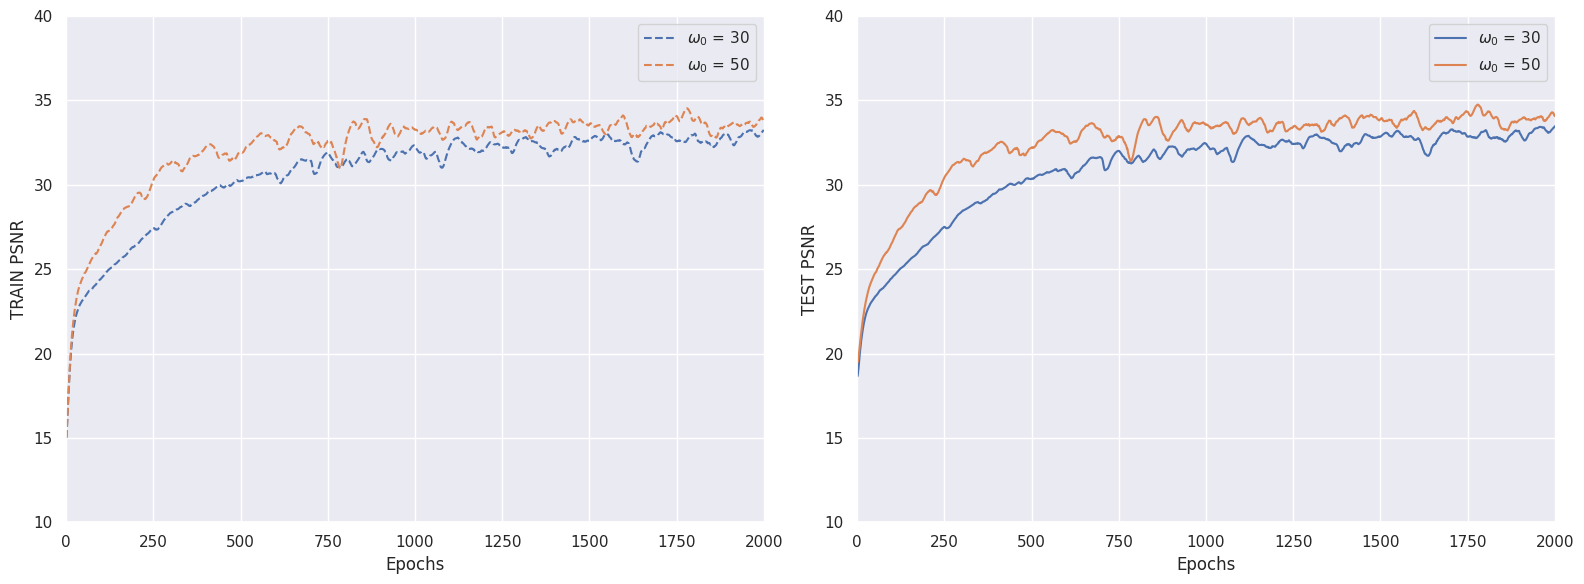

In [27]:
# Define metrics to plot (PSNR for training and validation) and their corresponding y-axis labels.
metrics = ['psnr', 'test_psnr']  # 'psnr' for training, 'val_psnr' for validation
y_labels = ['TRAIN PSNR', 'TEST PSNR']  # Labels for the y-axis

# Define the y-axis limits for plotting PSNR values. This helps in comparing models more effectively by using the same scale.
y_limits = [(10, 40), (10, 40)]  # Sets the minimum and maximum for y-axis in PSNR plots

# Call the plot_metrics function with the defined parameters to visualize the performance of the models.
plot_metrics(dics, metrics, y_labels, y_limits, smooth=0.9)


In [28]:
# Select specific indices for demonstration or analysis.
#indices = [0, 3, 6, 10, 14, 17, 20]
indices = [1, 4, 11, 17]

# Gather selected coordinates and original images, adding a batch dimension for processing.
selected_coords = [coords[i].unsqueeze(0) for i in indices]
original_images = [images[i].unsqueeze(0) for i in indices]

# Create labels for generated images and original (ground truth) images with specific lambda values.
labels_generated = [f"generated $\\lambda_{{{index + 1}}}$" for index in indices]
labels_original = [f"original (GT) $\\lambda_{{{index + 1}}}$" for index in indices]

# Process each selected image through the model to generate new images.
generated_images = [model_30(image) for image in selected_coords]

# Concatenate tensors of generated and original images into one batch for plotting.
all_images = torch.cat(generated_images + original_images, dim=0).squeeze().detach().numpy()

# Concatenate labels for generated and original images.
all_labels = labels_generated + labels_original

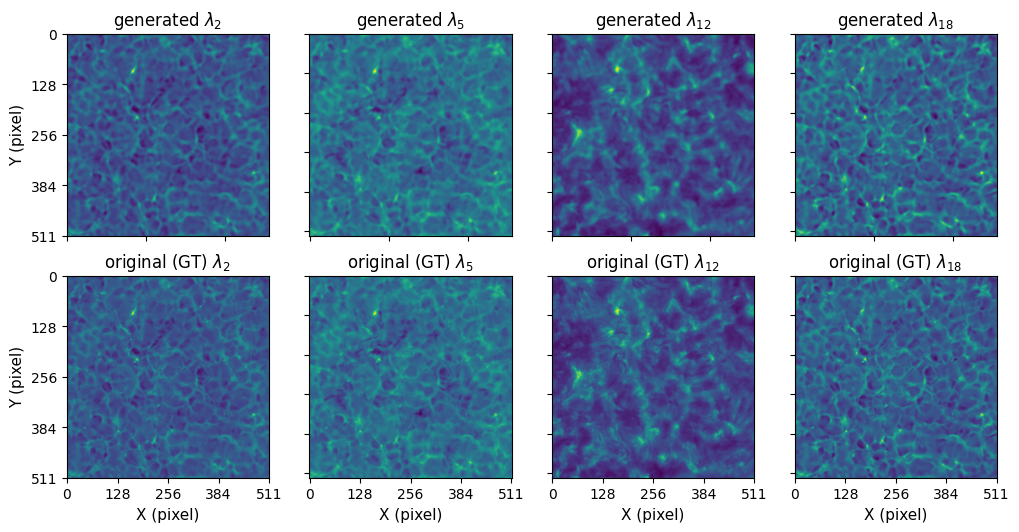

In [29]:
# Utilizes the 'plot_data' function from the 'utils' module to display the images.
# The images are arranged in a grid with 3 columns, and each image is labeled according to the 'labels' list.
plot_data(dataset=all_images, num_columns=len(indices),
          labels=all_labels, tick_size=10,
          title_size=12, axis_size=11,
          path=IMAGES_PATH, img_name='generated_and_GT_test',
          hspace=0.1, wspace=0.2)

In [30]:
# Select specific indices for demonstration or analysis.
#indices = [0, 3, 6, 10, 14, 17, 20]
indices = [1, 4, 11, 17]

# Gather selected coordinates and original images, adding a batch dimension for processing.
selected_coords = [coords[i].unsqueeze(0) for i in indices]
original_images = [images[i].unsqueeze(0) for i in indices]

# Create labels for generated images and original (ground truth) images with specific lambda values.
labels_generated = [f"generated $\\lambda_{{{index + 1}}}$" for index in indices]
labels_original = [f"original (GT) $\\lambda_{{{index + 1}}}$" for index in indices]

# Process each selected image through the model to generate new images.
generated_images = [model_50(image) for image in selected_coords]

# Concatenate tensors of generated and original images into one batch for plotting.
all_images = torch.cat(generated_images + original_images, dim=0).squeeze().detach().numpy()

# Concatenate labels for generated and original images.
all_labels = labels_generated + labels_original

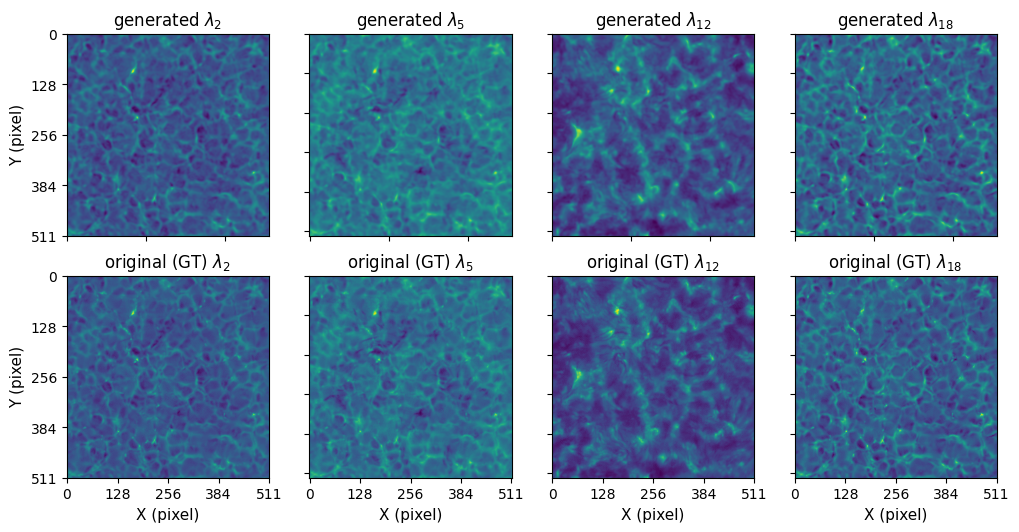

In [31]:
# Utilizes the 'plot_data' function from the 'utils' module to display the images.
# The images are arranged in a grid with 3 columns, and each image is labeled according to the 'labels' list.
plot_data(dataset=all_images, num_columns=len(indices),
          labels=all_labels, tick_size=10,
          title_size=12, axis_size=11,
          path=IMAGES_PATH, img_name='generated_and_GT_test',
          hspace=0.1, wspace=0.2)